In [1]:
import string;
import gensim
from gensim import corpora, models
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

import pyLDAvis
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline

# We import sklearn.
import sklearn

import time

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nolanmccafferty/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
docs = []
titles = []
locations = []
lines = ''
title = ''
location = ''

In [3]:
with open('medical_assistant_1000_similar.txt', 'r') as rf:
    for line in rf:
        if location == '':
            location = line[:-1]
            locations.append(location)
        if title == '':
            title = line[:-1]
            titles.append(title)
            location = ''
        if line == 'zzz\n':
            docs.append(lines)
            lines = ''
            title = ''
            location = ''
        else:
            lines = lines+line 

In [4]:
# stop words
en_stop = get_stop_words('en')

In [5]:
# stemmer
p_stemmer = PorterStemmer()

In [6]:
documents = []

for i in docs:
    # tokenize text
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = [x.lower() for x in tokenizer.tokenize(i)]
    
    # remove stop words, numbers, and short words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop and len(i) > 3 and not i.isdigit()]
    
    # stem and lemmatize tokens
    stemmed_tokens = [p_stemmer.stem(WordNetLemmatizer().lemmatize(i, pos='v')) for i in stopped_tokens]
    
    # add tokens to list
    documents.append(stemmed_tokens)

In [7]:
# turn tokenize documents into a id - term dictionary
dictionary = corpora.Dictionary(documents)

len(dictionary)

6426

In [8]:
# filter out words that are too frequent or too infrequent
dictionary.filter_extremes(no_below=0.02, no_above=0.5, keep_n=100000)

len(dictionary)

6385

In [9]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(document) for document in documents]

In [10]:
# creating object for LDA model
Lda = gensim.models.ldamodel.LdaModel

def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = Lda(corpus, num_topics=num_topics, id2word=dictionary, passes=20)        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(num_topics)

    return model_list, coherence_values

In [11]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=documents, start=4, limit=16, step=2)

4
6
8
10
12
14


In [12]:
# Can take a long time to run, second half
model_list_2, coherence_values_2 = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=documents, start=16, limit=30, step=2)

16
18
20
22
24
26
28


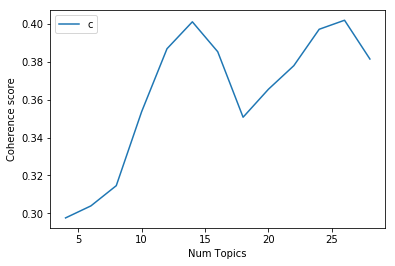

In [13]:
# Show graph
limit=30; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values + coherence_values_2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [14]:
# Print the coherence scores
for m, cv in zip(x, coherence_values + coherence_values_2):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.2976
Num Topics = 6  has Coherence Value of 0.3039
Num Topics = 8  has Coherence Value of 0.3146
Num Topics = 10  has Coherence Value of 0.3537
Num Topics = 12  has Coherence Value of 0.3869
Num Topics = 14  has Coherence Value of 0.4012
Num Topics = 16  has Coherence Value of 0.3854
Num Topics = 18  has Coherence Value of 0.3508
Num Topics = 20  has Coherence Value of 0.3656
Num Topics = 22  has Coherence Value of 0.378
Num Topics = 24  has Coherence Value of 0.3972
Num Topics = 26  has Coherence Value of 0.402
Num Topics = 28  has Coherence Value of 0.3815


In [15]:
# choose the model with the highest Conherence value 
# num_topics = 20
optimal_model = model_list[5]

# Visualize the topics
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary, mds="tsne")

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
9     -212.824890  -49.686375       1        1  15.034908
3     -157.252594   79.956261       2        1  10.634155
10      65.863640 -101.864433       3        1   9.661284
7      -25.046242 -199.320908       4        1   9.046582
6      -57.792934  154.185913       5        1   7.272272
11      59.461945  124.970222       6        1   7.259550
8      -31.889404   44.822166       7        1   7.245875
13     155.294022   54.348259       8        1   6.625665
5      102.642174 -201.842285       9        1   6.288496
1     -108.936966  -22.688463      10        1   5.033621
4       57.923737    0.699361      11        1   4.290040
12    -131.095276 -147.834030      12        1   4.191864
2      -30.611349  -81.486725      13        1   4.049190
0      172.546448  -68.937073      14        1   3.366495, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
147   Default   407.000000      social   407.000000  30.0000  30.0000
102   Default  1405.000000        nurs  1405.000000  29.0000  29.0000
866   Default   438.000000      client   438.000000  28.0000  28.0000
703   Default   569.000000        home   569.000000  27.0000  27.0000
155   Default  1135.000000      system  1135.000000  26.0000  26.0000
169   Default   298.000000  washington   298.000000  25.0000  25.0000
73    Default  1043.000000   healthcar  1043.000000  24.0000  24.0000
88    Default  1136.000000       manag  1136.000000  23.0000  23.0000
2032  Default   157.000000       seton   157.000000  22.0000  22.0000
203   Default   990.000000      famili   990.000000  21.0000  21.0000
248   Default   159.000000      spokan   159.000000  20.0000  20.0000
151   Default  1078.000000       statu  1078.000000  19.0000  19.0000
859   Default   306.000000         aid   306.000000  18.0000  18.0000
957   Default   922.000000        abil   922.000000  17.0000  17.0000
1703  Default   135.000000    carolina   135.000000  16.0000  16.0000
2179  Default   159.000000  ohiohealth   159.000000  15.0000  15.0000
19    Default   291.000000     caregiv   291.000000  14.0000  14.0000
54    Default   673.000000       equal   673.000000  13.0000  13.0000
146   Default   602.000000       shift   602.000000  12.0000  12.0000
853   Default   435.000000     univers   435.000000  11.0000  11.0000
140   Default  1087.000000     schedul  1087.000000  10.0000  10.0000
2696  Default   138.000000   jefferson   138.000000   9.0000   9.0000
104   Default   550.000000       offer   550.000000   8.0000   8.0000
609   Default   619.000000        plan   619.000000   7.0000   7.0000
164   Default   738.000000        unit   738.000000   6.0000   6.0000
268   Default   381.000000      action   381.000000   5.0000   5.0000
520   Default   335.000000       deliv   335.000000   4.0000   4.0000
1711  Default   162.000000      hospic   162.000000   3.0000   3.0000
55    Default   452.000000       equip   452.000000   2.0000   2.0000
274   Default   313.000000      assess   313.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
252   Topic14    33.218891      trauma   120.951797   2.0990  -5.3343
1651  Topic14    17.700771        lcsw    45.360565   2.4503  -5.9638
957   Topic14   117.158409        abil   922.146423   1.3281  -4.0739
1243  Topic14    51.705772     essenti   270.650848   1.7360  -4.8919
675   Topic14    23.914598         ill    77.125740   2.2203  -5.6629
2942  Topic14    17.636526       typic    46.969788   2.4118  -5.9675
293   Topic14    34.467964     counsel   154.781067   1.8893  -5.2974
203   Topic14    94.864746      famili   990.295837   1.0457  -4.2850
274   Topic14    49.626785      assess   313.964661   1.5465  -4.9329
563   Topic14    78.796761    knowledg   825.509644   1.0422  -4.4706
677   Topic14    35

In [95]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=documents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=documents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.7643,"learn, test, platform, compani, innov, world, ...","[softwar, engin, mossvil, posit, softwar, engi..."
1,1,3.0,0.7000,"learn, test, platform, compani, innov, world, ...","[softwar, engin, cloud, python, java, amrd2087..."
2,2,2.0,0.7871,"test, secur, analyt, analysi, use, analyst, in...","[core, java, develop, york, descript, core, ja..."
3,3,2.0,0.8779,"test, secur, analyt, analysi, use, analyst, in...","[full, stack, java, engin, francisco, right, s..."
4,4,3.0,0.5045,"learn, test, platform, compani, innov, world, ...","[entri, level, softwar, engin, beaverton, entr..."
5,5,3.0,0.9955,"learn, test, platform, compani, innov, world, ...","[sync, emb, softwar, develop, supervisor, alle..."
6,6,1.0,0.3454,"amazon, test, oper, drive, write, excel, deliv...","[network, technician, data, center, seattl, am..."
7,7,2.0,0.6691,"test, secur, analyt, analysi, use, analyst, in...","[java, spring, develop, jersey, citi, descript..."
8,8,2.0,0.9904,"test, secur, analyt, analysi, use, analyst, in...","[java, microservic, develop, littleton, java, ..."
9,9,2.0,0.9818,"test, secur, analyt, analysi, use, analyst, in...","[softwar, engin, summer, intern, troy, underst..."


In [96]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9976,"server, network, administr, configur, troubles...","[corespac, junior, system, administr, dalla, h..."
1,1.0,0.9968,"amazon, test, oper, drive, write, excel, deliv...","[manag, content, oper, seattl, content, oper, ..."
2,2.0,0.9986,"test, secur, analyt, analysi, use, analyst, in...","[java, develop, intern, washington, summaryhel..."
3,3.0,0.9973,"learn, test, platform, compani, innov, world, ...","[ccbd, technolog, back, develop, python, franc..."
4,4.0,0.9979,"employ, microsoft, statu, research, protect, d...","[intern, opportun, student, data, appli, scien..."


In [97]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,3.0,"learn, test, platform, compani, innov, world, ...",70.0,0.0699
1,3.0,"learn, test, platform, compani, innov, world, ...",128.0,0.1279
2,2.0,"test, secur, analyt, analysi, use, analyst, in...",384.0,0.3836
3,2.0,"test, secur, analyt, analysi, use, analyst, in...",211.0,0.2108
4,3.0,"learn, test, platform, compani, innov, world, ...",112.0,0.1119


In [99]:
topics = {}
vectors = []
for i,idx in enumerate(documents):
        # get the topic percentages for each document
        bow = dictionary.doc2bow(idx)
        v = optimal_model.get_document_topics(bow)
        
        # key => value, document number => topic vector
        topics[i] = v
        
        # iterate through the topic vector
        dict = {}
        for j,jdx in enumerate(v):
            # key => value, topic number => percentage of document
            dict[jdx[0]] = jdx[1]

        # give the dictionary 20 keys, one for each topic
        vector = []
        for k in range(6):
            # if the topic was in the original vector, use the given percentage
            if k in dict.keys():
                vector.append(dict[k])
            # else give the topic the percentage zero
            else:
                vector.append(0)
        # add the vector to the set of document vectors
        vectors.append(np.asarray([vector]))

In [100]:
def top_5_similar(vectors):
    for j in range(5):
        index = np.random.randint(0,len(vectors)-1)
        cosines = {}
        euclideans = {}
        for i,ind in enumerate(vectors):
            if i != index:
                cosines[sklearn.metrics.pairwise.cosine_similarity(vectors[index],vectors[i])[0][0]] = i
                euclideans[sklearn.metrics.pairwise.euclidean_distances(vectors[index],vectors[i])[0][0]] = i

        top_5_cosine = sorted(cosines.keys(), reverse=True)[:6]
        top_5_euclidean = sorted(euclideans.keys())[:6]
        print("\nTop 5 cosine similarity to:", titles[index])
        for i,indx in enumerate(top_5_cosine):
            print("  ", round(top_5_cosine[i], 3), titles[cosines[top_5_cosine[i]]])
            
        print("Lowest 5 euclidean distance from:", titles[index])
        for k,inx in enumerate(top_5_euclidean):
            print("  ", round(top_5_euclidean[k], 3), titles[euclideans[top_5_euclidean[k]]])

In [101]:
top_5_similar(vectors)


Top 5 cosine similarity to: Software Engineer Equal Opportunity
   1.0 Cyber Threat Intelligence Analyst I
   1.0 Developer II
   1.0 Back-end Java Developer
   1.0 Jr. Java Developer
   0.999 Software Engineer - Python / AWS
   0.999 Data Science Internship
Lowest 5 euclidean distance from: Software Engineer Equal Opportunity
   0.009 Developer II
   0.017 Cyber Threat Intelligence Analyst I
   0.02 Back-end Java Developer
   0.03 Jr. Java Developer
   0.032 Software Engineer - Python / AWS
   0.037 Data Science Internship

Top 5 cosine similarity to: Software Engineer
   1.0 Product Analyst
   1.0 Senior Researcher
   1.0 Analytics Developer/Analyst
   1.0 Marketing Modeler
   1.0 Penetration Tester - Application Security
   0.999 Entry Level Associate Software Engineer/Business Analyst
Lowest 5 euclidean distance from: Software Engineer
   0.015 Product Analyst
   0.023 Senior Researcher
   0.024 Analytics Developer/Analyst
   0.029 Marketing Modeler
   0.037 Penetration Tester - A

In [73]:
def top_1000_similar(vectors):
        indices = []
        index = 32535
        cosines = {}
        for i,ind in enumerate(vectors):
            if i != index:
                cosines[sklearn.metrics.pairwise.cosine_similarity(vectors[index],vectors[i])[0][0]] = i

        top_1000_cosine = sorted(cosines.keys(), reverse=True)[:1001]
        print("\nTop 10 cosine similarity to:", titles[index])
        for i,ind in enumerate(top_1000_cosine):
            print("  ", round(ind, 3), titles[cosines[ind]])
            indices.append(cosines[ind])
            
        return indices

indices = top_1000_similar(vectors)


Top 10 cosine similarity to: Sales Associate
   0.997 Sales Closers B2B
   0.996 Customer Service Representative
   0.996 Phone Sales Expert
   0.994 Entry Level sale Representative
   0.993 Concierge
   0.993 Junior Consultant
   0.993 Canvassing Manager
   0.993 Inside Sales Representative - Dating Specialist
   0.992 Inside Sales Representative - Dating Specialist
   0.992 Entry Level Medical Sales
   0.991 Call Center Customer Service Rep
   0.989 Inside Sales Representative - Dating Specialist
   0.988 Associate Orthodontist
   0.987 Inside Sales Representative - Dating Specialist
   0.987 Entry Level Marketing
   0.986 Call Center Representative
   0.986 Sales Representative
   0.985 Customer Service Representative/Call Center
   0.985 Wax Specialist
   0.985 Sales Associate/Customer Service
   0.985 Cell Phone Sales
   0.984 Inside Sales Representative
   0.984 Hiring precious metals appointment setters today!
   0.984 Business to Business Appointment Setters
   0.984 Verizon W

   0.916 Sales Rep
   0.916 Office Assistant
   0.916 Inside Sales Associate
   0.916 BDC Associate
   0.916 Wine Sales Representative
   0.916 Residential Field Sales Representative - Outside Sales
   0.916 Secretary
   0.916 Stellar Optician
   0.915 Sales Associate/Product Specialist
   0.915 Sales-no cold calls-EB-Part/Full time 70%-80% buyers
   0.915 Outside Sales Representative
   0.915 Call Center Medical Telesales Representative
   0.915 Personal Administrative Assistant/ Marketing Coordinator
   0.915 Entry Level Associate
   0.915 Front Desk Receptionist for Upscale Men's Salon
   0.915 Sales Reps Needed!
   0.915 Call Center Customer Service Representative
   0.914 Dealership Account Manager
   0.914 Inside Sales Associate
   0.914 Entry Level Sales Representative
   0.914 Brand Ambassador
   0.914 Sales Consultant
   0.914 Outside Sales Representative - B2B Medical
   0.914 Licensed Br 3 Termite Inspector ($4,500 Sign on Bonus)
   0.914 Fitness Directors & Assistant Direct

   0.888 Customer Service Representative
   0.888 Home based Call Center Representative
   0.888 Receptionist - State Farm Agent Team Member
   0.888 Solar Energy Consultant- All Levels
   0.888 Personal Assistant
   0.888 Receptionist - State Farm Agent Team Member
   0.888 Benefits Coordinator
   0.888 Receptionist - State Farm Agent Team Member
   0.888 Receptionist - State Farm Agent Team Member
   0.888 Receptionist - State Farm Agent Team Member
   0.888 Assistant Personal Training Director
   0.888 Account Representative
   0.888 Receptionist - State Farm Agent Team Member
   0.888 Water sample collector/ Surveyor
   0.888 Business Development Coordinator
   0.887 Entry Level Account Manager
   0.887 Customer Relations Specialist
   0.887 Vacation Sales Consultant
   0.887 Inside Sales Representative/ Account Manager
   0.887 In- home Sales Opportunity
   0.887 Sales Consultant
   0.887 Receptionist - State Farm Agent Team Member
   0.887 Sale Associate
   0.887 Call Center Repr

In [74]:
"""write out top 1000 similar jobs to new file"""
filename = titles[32535].replace(" ", "_") + '_1000_similar.txt'
with open(filename, 'w') as wf:
    for i in indices:
        wf.write(docs[i])
        wf.write('zzz\n')

In [75]:
filename = titles[32535].replace(" ", "_") + '_1000_similar.txt'
filename

'Sales_Associate_1000_similar.txt'